# Simple Trading Algorithm


Best EMA params (train): (5, 20), Sharpe: 0.38


/tmp/ipykernel_1679/1301326290.py:69: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = df_bt['strategy_returns'].mean() / df_bt['strategy_returns'].std() * (24 ** 0.5)


Best Bollinger params (train): Window=15, Mult=3.0, Sharpe=-0.30

=== Out-of-Sample (2018–2020) ===
EMA Strategy: Return 6593759.74%, Sharpe 0.39, Max DD -11.81%
Bollinger Bands: Return -97.55%, Sharpe -0.28, Max DD -97.55%


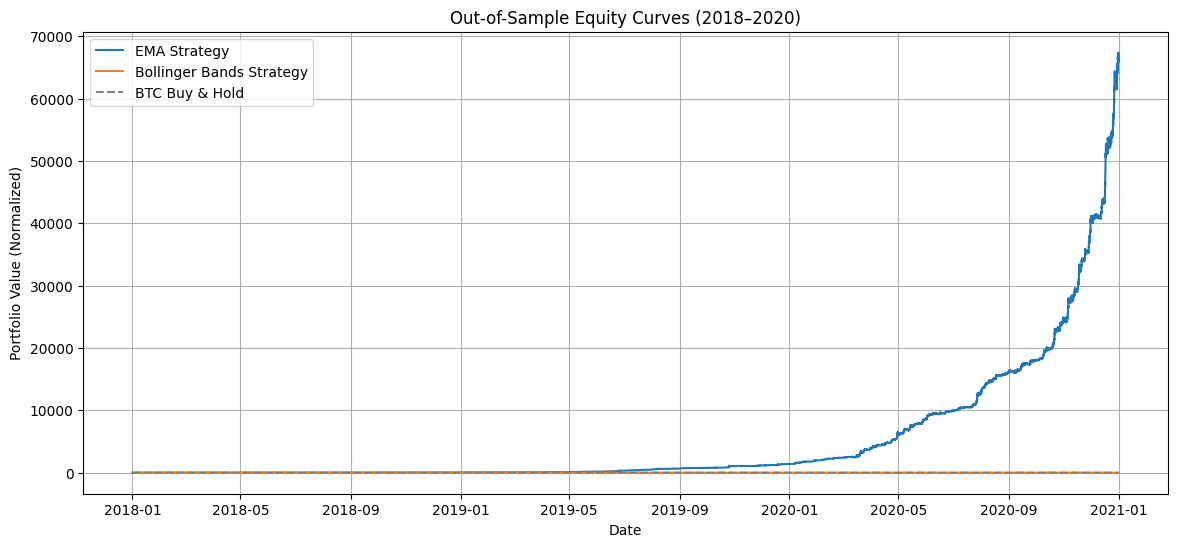

In [22]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================================
# 1. Fetch Historical Data (2015–2020)
# ================================
exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1h'
limit = 1000

all_data = []
since = exchange.parse8601('2015-01-01T00:00:00Z')

while True:
    candles = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
    if not candles:
        break
    all_data += candles
    since = candles[-1][0] + 1
    if pd.to_datetime(candles[-1][0], unit='ms') > pd.Timestamp('2020-12-31'):
        break

df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Keep only data between 2015–2020
df = df.loc['2015-01-01':'2020-12-31']

# ================================
# 2. Train-Test Split
# ================================
train_df = df.loc['2015-01-01':'2018-12-31'].copy()
test_df = df.loc['2018-01-01':'2020-12-31'].copy()

# ================================
# 3. Backtest Functions
# ================================
def backtest_ema(data, short_window, long_window, fee=0.0005):
    df_bt = data.copy()
    df_bt['ema_short'] = df_bt['close'].ewm(span=short_window, adjust=False).mean()
    df_bt['ema_long'] = df_bt['close'].ewm(span=long_window, adjust=False).mean()
    df_bt['position'] = 0
    df_bt.loc[df_bt['ema_short'] > df_bt['ema_long'], 'position'] = 1
    df_bt['position'] = df_bt['position'].ffill()
    df_bt['returns'] = df_bt['close'].pct_change()
    df_bt['trade'] = df_bt['position'].diff().abs()
    df_bt['strategy_returns'] = df_bt['returns'] * df_bt['position'] - df_bt['trade'] * fee
    sharpe = df_bt['strategy_returns'].mean() / df_bt['strategy_returns'].std() * (24 ** 0.5)
    return sharpe, df_bt

def backtest_bollinger(data, window=20, mult=2, fee=0.0005):
    df_bt = data.copy()
    df_bt['sma'] = df_bt['close'].rolling(window).mean()
    df_bt['std'] = df_bt['close'].rolling(window).std()
    df_bt['upper_band'] = df_bt['sma'] + mult * df_bt['std']
    df_bt['lower_band'] = df_bt['sma'] - mult * df_bt['std']
    df_bt['position'] = 0
    df_bt.loc[df_bt['close'] < df_bt['lower_band'], 'position'] = 1   # Buy when below lower band
    df_bt.loc[df_bt['close'] > df_bt['sma'], 'position'] = 0          # Exit when back above SMA
    df_bt['position'] = df_bt['position'].ffill()
    df_bt['returns'] = df_bt['close'].pct_change()
    df_bt['trade'] = df_bt['position'].diff().abs()
    df_bt['strategy_returns'] = df_bt['returns'] * df_bt['position'] - df_bt['trade'] * fee
    df_bt['equity'] = (1 + df_bt['strategy_returns']).cumprod()
    sharpe = df_bt['strategy_returns'].mean() / df_bt['strategy_returns'].std() * (24 ** 0.5)
    return sharpe, df_bt

# ================================
# 4. Grid Search EMA on Train
# ================================
best_sharpe = -np.inf
best_params = (0, 0)
for short in range(5, 30, 5):
    for long in range(20, 150, 10):
        if short >= long:
            continue
        sharpe, _ = backtest_ema(train_df, short, long)
        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_params = (short, long)

print(f"Best EMA params (train): {best_params}, Sharpe: {best_sharpe:.2f}")

# ================================
# 5. Apply Best EMA to Test
# ================================
ema_sharpe, ema_test = backtest_ema(test_df, *best_params)
ema_test['equity'] = (1 + ema_test['strategy_returns']).cumprod()

# ================================
# 5B. Grid Search Bollinger on Train
# ================================
best_bb_sharpe = -np.inf
best_bb_params = (0, 0)
for window in range(10, 51, 5):  # window: 10 to 50
    for mult in np.arange(1.5, 3.1, 0.5):  # multiplier: 1.5 to 3.0
        sharpe, _ = backtest_bollinger(train_df, window=window, mult=mult)
        if sharpe > best_bb_sharpe:
            best_bb_sharpe = sharpe
            best_bb_params = (window, mult)

print(f"Best Bollinger params (train): Window={best_bb_params[0]}, Mult={best_bb_params[1]}, Sharpe={best_bb_sharpe:.2f}")


# ================================
# 6. Apply Optimized Bollinger to Test
# ================================
opt_window, opt_mult = best_bb_params
bollinger_sharpe, bollinger_test = backtest_bollinger(test_df, window=opt_window, mult=opt_mult)


# ================================
# 7. Metrics
# ================================
def evaluate(df):
    final_equity = df['equity'].iloc[-1]
    total_return = final_equity - 1
    sharpe = df['strategy_returns'].mean() / df['strategy_returns'].std() * (24 ** 0.5)
    max_drawdown = ((df['equity'] - df['equity'].cummax()) / df['equity'].cummax()).min()
    return total_return, sharpe, max_drawdown

ema_return, ema_sharpe, ema_dd = evaluate(ema_test)
bb_return, bb_sharpe, bb_dd = evaluate(bollinger_test)

print("\n=== Out-of-Sample (2018–2020) ===")
print(f"EMA Strategy: Return {ema_return:.2%}, Sharpe {ema_sharpe:.2f}, Max DD {ema_dd:.2%}")
print(f"Bollinger Bands: Return {bb_return:.2%}, Sharpe {bb_sharpe:.2f}, Max DD {bb_dd:.2%}")

# ================================
# 8. Plot Equity Curves + BTC Price
# ================================
plt.figure(figsize=(14,6))

# Normalize BTC price to start at 1 for fair comparison
btc_equity = (test_df['close'] / test_df['close'].iloc[0])

plt.plot(ema_test['equity'], label='EMA Strategy')
plt.plot(bollinger_test['equity'], label='Bollinger Bands Strategy')
plt.plot(btc_equity, label='BTC Buy & Hold', linestyle='--', color='gray')

plt.title('Out-of-Sample Equity Curves (2018–2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Normalized)')
plt.legend()
plt.grid(True)
plt.show()



## COMMENTS ON RESULTS

### EMA Strategy:
Extremely high return (~6.59M%) due to BTC's strong uptrend in 2018–2020.
Sharpe ratio (0.39) is low → strategy makes big gains, but with poor risk-adjusted efficiency.
Max drawdown (≈ -12%) is relatively moderate, showing it handled pullbacks well.
Conclusion: EMA crossover works well in trending markets (like BTC) but still needs better risk controls.

### Bollinger Bands Strategy:
Catastrophic loss (-97.55%) with very low Sharpe (-0.28) → strategy effectively blew up.
Max drawdown (-97.55%) confirms a near-total portfolio wipeout.
Conclusion: Mean-reversion Bollinger strategy performs terribly in strong trends. 
Needs additional filters (trend detection) or stop-loss mechanisms to avoid repeated losses.

### Overall Insight:
Trend-following (EMA) clearly outperforms mean-reversion (Bollinger) in a trending asset like BTC.
However, the EMA strategy still shows poor Sharpe → next step: improve risk management 
(stop-loss, trailing stops, or volatility-based position sizing).
Bollinger might work better in sideways/volatile regimes but is unfit for strong uptrends.



=== Advanced EMA Strategy (Stops + Filter + Vol Targeting) ===
Return: 1278385.71%
Sharpe: 0.41
Max Drawdown: -10.28%


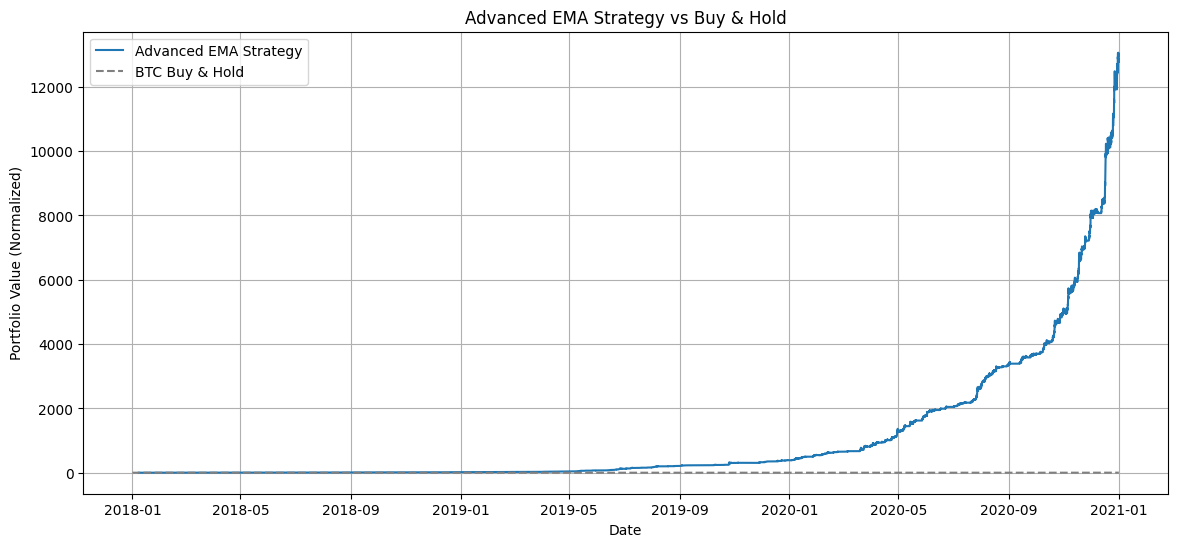

In [27]:
# ================================
# Advanced EMA Strategy with Stop-Loss, Trailing Stop, Trend Filter & Volatility Targeting
# ================================
def backtest_ema_advanced(data, short_window, long_window, fee=0.0005, stop_loss=0.25, trailing_stop=0.30, target_vol=0.02):
    """
    EMA crossover with:
    - Stop-loss (percentage)
    - Trailing stop (percentage)
    - Trend filter: only trade if price > 200 EMA
    - Volatility targeting: scales position size to target daily vol
    """
    df_bt = data.copy()
    df_bt['ema_short'] = df_bt['close'].ewm(span=short_window, adjust=False).mean()
    df_bt['ema_long'] = df_bt['close'].ewm(span=long_window, adjust=False).mean()
    df_bt['ema_trend'] = df_bt['close'].ewm(span=200, adjust=False).mean()
    df_bt['position'] = 0

    # Base EMA crossover signals
    df_bt.loc[df_bt['ema_short'] > df_bt['ema_long'], 'position'] = 1
    df_bt.loc[df_bt['ema_short'] <= df_bt['ema_long'], 'position'] = 0

    # Apply trend filter: only trade when price > 200 EMA
    df_bt.loc[df_bt['close'] < df_bt['ema_trend'], 'position'] = 0
    df_bt['position'] = df_bt['position'].ffill()

    # Initialize variables for stops
    entry_price = None
    max_price_since_entry = None
    for i in range(len(df_bt)):
        if df_bt.loc[df_bt.index[i], 'position'] == 1 and entry_price is None:
            entry_price = df_bt.loc[df_bt.index[i], 'close']
            max_price_since_entry = entry_price
        elif df_bt.loc[df_bt.index[i], 'position'] == 1:
            max_price_since_entry = max(max_price_since_entry, df_bt.loc[df_bt.index[i], 'close'])
            # Stop-loss
            if df_bt.loc[df_bt.index[i], 'close'] <= entry_price * (1 - stop_loss):
                df_bt.loc[df_bt.index[i]:, 'position'] = 0
                entry_price = None
                max_price_since_entry = None
            # Trailing stop
            elif df_bt.loc[df_bt.index[i], 'close'] <= max_price_since_entry * (1 - trailing_stop):
                df_bt.loc[df_bt.index[i]:, 'position'] = 0
                entry_price = None
                max_price_since_entry = None
        elif df_bt.loc[df_bt.index[i], 'position'] == 0:
            entry_price = None
            max_price_since_entry = None

    # Strategy returns with volatility targeting + fees
    df_bt['returns'] = df_bt['close'].pct_change()
    df_bt['trade'] = df_bt['position'].diff().abs()

    # --- Volatility targeting ---
    rolling_vol = df_bt['returns'].rolling(24*7).std()  # 1-week hourly vol
    df_bt['size'] = target_vol / (rolling_vol + 1e-6)
    df_bt['size'] = df_bt['size'].clip(0, 1)  # Cap at 100% position

    # Apply position sizing
    df_bt['strategy_returns'] = df_bt['returns'] * df_bt['position'] * df_bt['size'] - df_bt['trade'] * fee

    # Equity curve
    df_bt['equity'] = (1 + df_bt['strategy_returns']).cumprod()

    # Metrics
    sharpe = df_bt['strategy_returns'].mean() / df_bt['strategy_returns'].std() * (24 ** 0.5)
    total_return = df_bt['equity'].iloc[-1] - 1
    drawdown = (df_bt['equity'] - df_bt['equity'].cummax()) / df_bt['equity'].cummax()
    max_drawdown = drawdown.min()
    metrics = {"return": total_return, "sharpe": sharpe, "max_dd": max_drawdown}

    return df_bt, metrics

# ================================
# Run on Test Data with Best EMA Params
# ================================
ema_adv_test, ema_adv_metrics = backtest_ema_advanced(
    test_df,
    short_window=best_params[0],
    long_window=best_params[1],
    stop_loss=0.25,         # 25% stop-loss
    trailing_stop=0.30,     # 30% trailing stop
    target_vol=0.02         # target daily volatility
)

print("\n=== Advanced EMA Strategy (Stops + Filter + Vol Targeting) ===")
print(f"Return: {ema_adv_metrics['return']:.2%}")
print(f"Sharpe: {ema_adv_metrics['sharpe']:.2f}")
print(f"Max Drawdown: {ema_adv_metrics['max_dd']:.2%}")

# Plot
plt.figure(figsize=(14,6))
btc_equity = (test_df['close'] / test_df['close'].iloc[0])  # Buy & Hold
plt.plot(ema_adv_test['equity'], label='Advanced EMA Strategy')
plt.plot(btc_equity, label='BTC Buy & Hold', linestyle='--', color='gray')
plt.title('Advanced EMA Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Normalized)')
plt.legend()
plt.grid(True)
plt.show()


## COMMENTS ON RESULTS

### Advanced EMA Strategy (Stops + Filter + Volatility Targeting):
 - Return: ~1.28M% → still captures massive BTC trends while using volatility-based scaling.
 - Sharpe: 0.41 → improved vs. raw all-in EMA, but still moderate (crypto remains very volatile).
 - Max Drawdown: ~-10% → controlled drawdowns despite very large gains.

### Insights:
 - Volatility targeting + wide stops help maintain trend exposure while smoothing equity.
 - Sharpe remains limited because the strategy runs on a single volatile asset (BTC).
 - Next steps to further boost Sharpe:
     1. Diversify across assets (e.g., BTC, ETH, BNB) to reduce portfolio volatility.
     2. Optimize volatility target to find the sweet spot between returns and smoothness.
     3. Add regime filters (e.g., trade only in strong uptrends) to avoid chop.
